# Convert TensorFlow Object Detection API Models
[Documentation](https://software.intel.com/en-us/articles/OpenVINO-Using-TensorFlow#inpage-nav-6)

### Custom configs and meta data

In [1]:
# Path to the frozen TensorFlow object detection model.
pb_file = "./models/ssd_mobilenet_v2_custom_trained/frozen_inference_graph.pb"

# OpenVINO subgraph replacement configuration file that describes rules to convert specific TensorFlow topologies.
# Read more in Model optimization section.
configuration_file = 'deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json'

# The modified pipline config file used for training.
pipeline = './models/ssd_mobilenet_v2_custom_trained/ssd_mobilenet_v2_coco.config'

# Devices: GPU (intel), CPU or MYRIAD
plugin_device = 'GPU'

# Specify a data type for the given device or set to `None` to let the code decide.
# Data type 'FP16' or 'FP32' depends on what device to run the converted model.
# FP16: GPU and MYRIAD
# FP32 CPU and GPU
data_type = None

# Converted model take fixed size image as input,
# we simply use same size for image width and height.
img_height = 300

# Path to a sample image to inference.
fname = '../test/15.jpg'


# Model Optimizer can create an event file that can be then fed to the TensorBoard tool.(Optional)
tensorboard_logdir = None  # './models/ssd_mobilenet_v2_coco_2018_03_29/mo_tensorboard'

In [2]:
import os
model_dir = os.path.dirname(os.path.realpath(pb_file))

DATA_TYPE_MAP = {
    'GPU': 'FP16',
    'CPU': 'FP32',
    'MYRIAD': 'FP16'
}

assert plugin_device in DATA_TYPE_MAP, 'Unsupported device: `{}`, not found in `{}`'.format(
    plugin_device, list(DATA_TYPE_MAP.keys()))

if data_type is None:
    data_type = DATA_TYPE_MAP.get(plugin_device)

# Directory to save the converted model xml and bin files.
output_dir = os.path.join(
    model_dir, data_type)

## Model optimization

`--tensorflow_use_custom_operations_config <path_to_subgraph_replacement_configuration_file.json>`

- A subgraph replacement configuration file that describes rules to convert specific TensorFlow* topologies. For the models downloaded from the TensorFlow* Object Detection API zoo, you can find the configuration files in the `<INSTALL_DIR>/deployment_tools/model_optimizer/extensions/front/tf`

Use:
- `ssd_v2_support.json` - for frozen SSD topologies from the models zoo.
- `faster_rcnn_support.json` - for frozen Faster R-CNN topologies from the models zoo.
- `faster_rcnn_support_api_v1.7.json` - for Faster R-CNN topologies trained manually using the TensorFlow* Object Detection API version 1.7.0 or higher.
- ...


If the `--input_shape` command line parameter is not specified, the Model Optimizer generates an input layer with the height and width as defined in the `pipeline.config`.

If the --input_shape `[1, H, W, 3]` command line parameter is specified, the Model Optimizer sets the input layer height to H and width to W and convert the model.


NOTE: If you convert a TensorFlow* Object Detection API model to use with the Inference Engine sample applications, you must specify the `--reverse_input_channels` parameter also.  The samples load images in `BGR` channels order, while TensorFlow* models were trained with images in `RGB` order. When the `--reverse_input_channels` command line parameter is specified, the Model Optimizer performs first convolution or other channel dependent operation weights modification so the output will be like the image is passed with `RGB` channels order.

In [3]:
import os

if tensorboard_logdir:
    tensorboard_logdir_arg = '--tensorboard_logdir {}'.format(
        tensorboard_logdir)
    os.makedirs(tensorboard_logdir, exist_ok=True)
    print(tensorboard_logdir_arg)
else:
    tensorboard_logdir_arg = ''

# Absolute path to `configuration_file`
configuration_file = os.path.join(
    os.environ["INTEL_CVSDK_DIR"], configuration_file)

# Prepare command line argument string.
input_shape = [1, img_height, img_height, 3]
input_shape_str = str(input_shape).replace(' ', '')
input_shape_str

'[1,300,300,3]'

Locate the path to `mo_tf.py` script.

In [4]:
import platform
is_win = 'windows' in platform.platform().lower()

if is_win:
    mo_tf_path = 'C:/Intel/computer_vision_sdk/deployment_tools/model_optimizer/mo_tf.py'
else:
    # mo_tf.py path in Linux
    mo_tf_path = '~/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo_tf.py'


Start the model optimization script.

In [5]:
!python {mo_tf_path} \
    --input_model {pb_file} \
    --output_dir {output_dir} \
    --tensorflow_use_custom_operations_config {configuration_file} \
    --tensorflow_object_detection_api_pipeline_config {pipeline} \
    --input_shape {input_shape_str} \
    --data_type {data_type} \
    {tensorboard_logdir_arg}

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	E:\SW_WS\Python_SW\object_detection_demo\deploy\./models/ssd_mobilenet_v2_custom_trained/frozen_inference_graph.pb
	- Path for generated IR: 	E:\SW_WS\Python_SW\object_detection_demo\deploy\models\ssd_mobilenet_v2_custom_trained\FP32
	- IR output name: 	frozen_inference_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,300,300,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Offload unsupported operations: 	False
	- Path to model dump for Tensor

## Inference test with OpenVINO Inference Engine(IE)

Check path like `C:\Intel\computer_vision_sdk\python\python3.5` or `~/intel/computer_vision_sdk/python/python3.5` exists in `PYTHONPATH`.

In [3]:
import os

output_dir = os.path.join(model_dir, data_type)
assert os.path.isdir(output_dir), '`{}` does not exist'.format(output_dir)

In [4]:
import platform
is_win = 'windows' in platform.platform().lower()
if is_win:
    message = 'Please run `C:\\Intel\\computer_vision_sdk\\bin\\setupvars.bat` before launching jupyter notebook.'
else:
    message = 'Add the following line to ~/.bashrc and re-run jupyternotebook.\nsource ~/intel/computer_vision_sdk/bin/setupvars.sh'

import os
assert 'computer_vision_sdk' in os.environ['PYTHONPATH'], message

In [5]:
from PIL import Image
import numpy as np
try:
    from openvino import inference_engine as ie
    from openvino.inference_engine import IENetwork, IEPlugin
except Exception as e:
    exception_type = type(e).__name__
    print("The following error happened while importing Python API module:\n[ {} ] {}".format(
        exception_type, e))
    sys.exit(1)

In [6]:
import glob
import os

# Plugin initialization for specified device and load extensions library if specified.
plugin_dir = None
model_xml = glob.glob(os.path.join(output_dir, '*.xml'))[-1]
model_bin = glob.glob(os.path.join(output_dir, '*.bin'))[-1]
# Devices: GPU (intel), CPU, MYRIAD
plugin = IEPlugin(plugin_device, plugin_dirs=plugin_dir)
# Read IR
net = IENetwork(model=model_xml, weights=model_bin)
assert len(net.inputs.keys()) == 1
assert len(net.outputs) == 1
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
# Load network to the plugin
exec_net = plugin.load(network=net)
del net

In [7]:
def pre_process_image(imagePath, img_shape):
    """pre process an image from image path.
    
    Arguments:
        imagePath {str} -- input image file path.
        img_shape {tuple} -- Target height and width as a tuple.
    
    Returns:
        np.array -- Preprocessed image.
    """

    # Model input format
    assert isinstance(img_shape, tuple) and len(img_shape) == 2

    n, c, h, w = [1, 3, img_shape[0], img_shape[1]]
    image = Image.open(imagePath)
    processed_img = image.resize((h, w), resample=Image.BILINEAR)

    processed_img = np.array(processed_img).astype(np.uint8)

    # Change data layout from HWC to CHW
    processed_img = processed_img.transpose((2, 0, 1))
    processed_img = processed_img.reshape((n, c, h, w))

    return processed_img, np.array(image)


In [8]:
# Run inference
img_shape = (img_height, img_height)
processed_img, image = pre_process_image(fname, img_shape)
res = exec_net.infer(inputs={input_blob: processed_img})

In [9]:
print(res['DetectionOutput'].shape)

(1, 1, 100, 7)


The Inference Engine DetectionOutput layer implementation produces one tensor with seven numbers for each actual detection:

- 0: batch index
- 1: class label
- 2: class probability
- 3: x_1 box coordinate (0~1 as a fraction of the image width reference to the upper left corner)
- 4: y_1 box coordinate (0~1 as a fraction of the image height reference to the upper left corner)
- 5: x_2 box coordinate (0~1 as a fraction of the image width reference to the upper left corner)
- 6: y_2 box coordinate (0~1 as a fraction of the image height reference to the upper left corner)

Filter the results with a prediction probability threshold.

In [10]:
probability_threshold = 0.5

preds = [pred for pred in res['DetectionOutput'][0][0] if pred[2] > probability_threshold]

In [11]:
preds

[array([0.        , 1.        , 1.        , 0.1611385 , 0.25168306,
        0.38256535, 0.49008846], dtype=float32),
 array([0.        , 1.        , 0.9941406 , 0.08566592, 0.44687837,
        0.23701021, 0.682599  ], dtype=float32),
 array([0.        , 1.        , 0.9560547 , 0.18232512, 0.67237616,
        0.3653468 , 0.8899634 ], dtype=float32),
 array([0.        , 2.        , 0.9921875 , 0.63862455, 0.18778378,
        0.8280066 , 0.44883233], dtype=float32),
 array([0.        , 2.        , 0.8461914 , 0.4341954 , 0.09646764,
        0.5751848 , 0.28985792], dtype=float32),
 array([0.        , 3.        , 0.8989258 , 0.4558125 , 0.75835305,
        0.5628856 , 0.90358335], dtype=float32)]

## Visualize the detection results

Predict class label:1, with probability: 1.00
Predict class label:1, with probability: 0.99
Predict class label:1, with probability: 0.96
Predict class label:2, with probability: 0.99
Predict class label:2, with probability: 0.85
Predict class label:3, with probability: 0.90


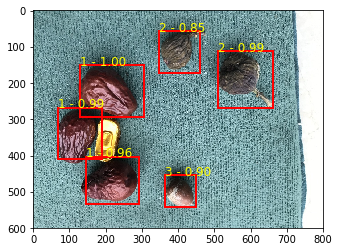

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
ax = plt.subplot(1, 1, 1)
plt.imshow(image)  # slice by z axis of the box - box[0].

for pred in preds:
    class_label = pred[1]
    probability = pred[2]
    print('Predict class label:{:.0f}, with probability: {:.2f}'.format(
        class_label, probability))
    box = pred[3:]
    box = (box * np.array(image.shape[:2][::-1] * 2)).astype(int)
    x_1, y_1, x_2, y_2 = box
    rect = patches.Rectangle((x_1, y_1), x_2-x_1, y_2 -
                             y_1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_1, y_1, '{:.0f} - {:.2f}'.format(class_label,
                                               probability), fontsize=12, color='yellow')

### Benchmark the inference speed

In [13]:
import time
times = []
for i in range(20):
    start_time = time.time()
    res = exec_net.infer(inputs={input_blob: processed_img})
    delta = (time.time() - start_time)
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1/mean_delta
print('average(sec):{:.3f},fps:{:.2f}'.format(mean_delta,fps))

average(sec):0.020,fps:50.84


## Visualize frozen `.pb` file (optional)

### Option 1: Visualize the frozen `.pb` file with TensorBoard

In [ ]:
import os
log_dir = "./tensorboard"

pb_file = os.path.abspath(pb_file).replace('\\', '/')
log_dir = os.path.abspath(log_dir).replace('\\', '/')
os.makedirs(log_dir, exist_ok=True)
assert os.path.isfile(pb_file)
print('--model_dir {}'.format(pb_file))
print('--log_dir {}'.format(log_dir))

In [ ]:
from tensorflow.python.tools import import_pb_to_tensorboard

In [ ]:
# File path to `import_pb_to_tensorboard.py`
import_pb_to_tensorboard_py = import_pb_to_tensorboard.__file__
import_pb_to_tensorboard_py = import_pb_to_tensorboard_py.replace('\\', '/')
import_pb_to_tensorboard_py

#### Create TensorBoard event file.

In [ ]:
get_ipython().system_raw(
    'python {} --model_dir {} --log_dir {} &'
    .format(import_pb_to_tensorboard_py, pb_file, log_dir)
)

In [ ]:
!ls {log_dir}

#### Run TensorBoard

In [ ]:
get_ipython().system_raw(
    'tensorboard --logdir {} &'
    .format(log_dir)
)

### Option 2: Visualize with OpenVINO `summarize_graph.py` utility.
If you just want to know the input(s) and output(s) of the model.

In [3]:
import platform
is_win = 'windows' in platform.platform().lower()

if is_win:
    summarize_graph_path = 'C:/Intel/computer_vision_sdk/deployment_tools/model_optimizer/mo/utils/summarize_graph.py'
else:
    # summarize_graph.py path in Linux
    summarize_graph_path = '~/intel/computer_vision_sdk/deployment_tools/model_optimizer/mo/utils/summarize_graph.py'

In [4]:
!python {summarize_graph_path} --input_model {pb_file}

1 input(s) detected:
Name: image_tensor, type: uint8, shape: (-1,-1,-1,3)
4 output(s) detected:
detection_boxes
detection_scores
detection_classes
num_detections
